In [2]:
%matplotlib inline
import torch
import numpy as np
import os
import torch.distributions as tchd
import matplotlib.pyplot as plt
from tensorboardX import SummaryWriter
import datetime
from torch import nn
import random

In [4]:
device_name = 'cuda:0'
tch_device = torch.device(device_name)
tch_dtype = torch.double

In [3]:
class UStar2f:
    def __init__(self, mu_np, sigma_np, pi_np, device, dtype):
        self.mu = torch.nn.Parameter(torch.from_numpy(mu_np).to(device=device, dtype=dtype)) 
        # mu.shape = (k, d)
        self.sigma = torch.nn.Parameter(torch.from_numpy(sigma_np).to(device=device, dtype=dtype)) 
        # sigma.shape = (k, d)
        self.pi = torch.nn.Parameter(torch.from_numpy(pi_np).to(device=device, dtype=dtype)) 
        
        # Pytorch distribution objects
        self.pi_dist = tchd.Categorical(self.pi)
        self.norm_dists = tchd.Independent(tchd.Normal(self.mu, self.sigma), 1)
        self.gmm = tchd.MixtureSameFamily(self.pi_dist, self.norm_dists)
        
    def __call__(self, x):
        N, d = x.shape
        logu = self.gmm.log_prob(x)
        u = torch.exp(logu)
        u_x, = torch.autograd.grad(u.sum(), [x], grad_outputs=None, retain_graph=True,
                                   create_graph=True, only_inputs=True, allow_unused=False)
        f = 0
        for i in range(d):
            u_xxi, = torch.autograd.grad(u_x[:, i].sum(), [x], grad_outputs=None, retain_graph=True,
                                         create_graph=False, only_inputs=True, allow_unused=True)
            with torch.no_grad():
                f = f + u_xxi[:, i]
        return f, u

In [4]:
mu_np = np.array([[-0.5, -0.5], [0.5, 0.5]])
sigma_np = np.array([[0.25, 0.25], [0.25, 0.25]])
pi_np = np.array([0.5, 0.5])
ustar2f = UStar2f(mu_np, sigma_np, pi_np, tch_device, tch_dtype)

# 1. training data
x1_1d = torch.linspace(-1, 1, 50, requires_grad=True, dtype=tch_dtype, device=tch_device)
x2_1d = torch.linspace(-1, 1, 50, requires_grad=True, dtype=tch_dtype, device=tch_device)
x1_msh, x2_msh = torch.meshgrid(x1_1d, x2_1d, indexing='ij')
x1 = x1_msh.reshape(-1, 1)
x2 = x2_msh.reshape(-1, 1)
x = torch.cat([x1, x2], dim=1)


a = torch.cat([x1_1d.reshape(-1, 1), torch.full_like(x1_1d.reshape(-1, 1), x2_1d.min().item())], dim=1)
b = torch.cat([x1_1d.reshape(-1, 1), torch.full_like(x1_1d.reshape(-1, 1), x2_1d.max().item())], dim=1)
c = torch.cat([torch.full_like(x2_1d.reshape(-1, 1), x1_1d.min().item()), x2_1d.reshape(-1, 1)], dim=1)
d = torch.cat([torch.full_like(x2_1d.reshape(-1, 1), x1_1d.max().item()), x2_1d.reshape(-1, 1)], dim=1)
x_bc = torch.cat([a, b, c, d], dim=0)

f_true, u_true = ustar2f(x)
f_true = f_true.detach()
u_true = u_true.detach()

f_bc_true, u_bc_true = ustar2f(x_bc)
f_bc_true = f_bc_true.detach()
u_bc_true = u_bc_true.detach()

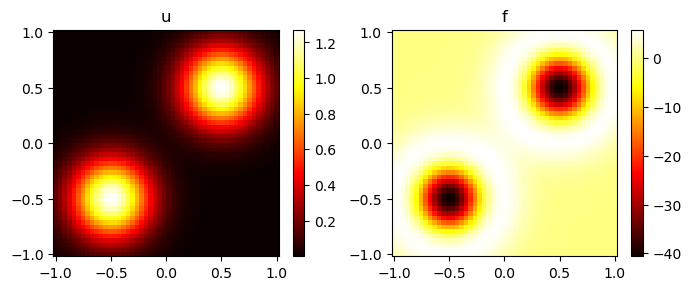

In [5]:
def do_plot(x_msh_np, t_msh_np, u_msh_np, f_msh_np=None):
    n_rows, n_cols = 1, 2 if f_msh_np is not None else 1
    plt.ioff()
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), dpi=100)
    axes = np.array(axes).reshape(n_rows, n_cols)
    ax = axes[0, 0]
    ax.set_title('u')
    im1 = ax.pcolormesh(t_msh_np, x_msh_np, u_msh_np, cmap='hot', shading='auto')
    fig.colorbar(im1, ax=ax)
    if f_msh_np is not None:
        ax = axes[0, 1]
        ax.set_title('f')
        im2 = ax.pcolormesh(t_msh_np, x_msh_np, f_msh_np, cmap='hot', shading='auto')
        fig.colorbar(im2, ax=ax)
    return fig

do_plot(x1_msh.detach().cpu().numpy(), x2_msh.detach().cpu().numpy(), 
        u_true.detach().cpu().numpy().reshape(*x1_msh.shape),
        f_true.detach().cpu().numpy().reshape(*x1_msh.shape))

In [6]:
class ffnn(nn.Module):
    """basic FF network for approximating functions"""
    def __init__(self, nn_width=10, num_hidden=2, x_dim=2, device=None, dtype=None):
        super().__init__()
        
        self.layer_first = nn.Linear(x_dim, nn_width).to(device=device, dtype=dtype)
        
        layers = []
        for _ in range(num_hidden):
            layers.append(nn.Linear(nn_width, nn_width).to(device=device, dtype=dtype))
        self.layer_hidden = nn.ModuleList(layers)
        
        self.layer_last = nn.Linear(nn_width, 2).to(device=device, dtype=dtype)
        
    def forward(self, x):
        xt = x
        activation = nn.SiLU()
        u = activation(self.layer_first(xt))
        for hidden in self.layer_hidden:
            u = activation(hidden(u))
        uf = self.layer_last(u)
        u, f = uf[:, 0], uf[:, 1]
        u = u.reshape(-1, 1)
        f = f.reshape(-1, 1)
        return u, f

In [7]:
! rm -rf training_logs/*

In [8]:
timestamp = datetime.datetime.now().isoformat(timespec='seconds')
writer = SummaryWriter(f'training_logs/train-{timestamp}')

# 2. set the model
torch.manual_seed(23939)
np.random.seed(23939)
random.seed(23939)
model = ffnn(15, 2, 2, device=tch_device, dtype=tch_dtype)

# 3. set the optimizer
lr = 0.001
opt = torch.optim.Adam(model.parameters(), lr)
n_epochs = 10000
loss_total_history = []
loss_data_history = []
loss_bc_history = []
loss_phys_history = []
u_history = []
f_history = []

for epoch in range(n_epochs):
    opt.zero_grad()
    x_mb, u_true_mb = x, u_true.reshape(-1, 1)
    u_mb, f_mb = model(x_mb)
    u_bc, f_bc = model(x_bc)
    
    N, d = x_mb.shape
    N_bc = x_bc.shape[0]
    assert u_true_mb.shape == (N, 1)
    assert u_mb.shape == (N, 1)
    assert f_mb.shape == (N, 1)
    assert u_bc.shape == (N_bc, 1)
    assert f_bc.shape == (N_bc, 1)
    assert x_bc.shape == (N_bc, d)
    
    u_x, = torch.autograd.grad(u_mb.sum(), [x_mb], grad_outputs=None, retain_graph=True,
                               create_graph=True, only_inputs=True, allow_unused=False)
    f_net_lst = []
    for i in range(d):
        u_xxi, = torch.autograd.grad(u_x[:, i].sum(), [x_mb], grad_outputs=None, retain_graph=True,
                                     create_graph=True, only_inputs=True, allow_unused=False)
        f_net_lst.append(u_xxi[:, i].reshape(N, 1))
    u_delta_mb = torch.cat(f_net_lst, dim=1).sum(dim=1, keepdim=True)
    assert u_delta_mb.shape == (N, 1)
    
    loss_data = torch.pow(u_mb - u_true_mb, 2).mean()
    loss_bc = torch.pow(u_bc - u_bc_true, 2).mean()
    loss_phys = torch.pow(u_delta_mb - f_mb, 2).mean()
    loss = loss_data + loss_bc * 1.0 + 0.01 * loss_phys
    
    loss.backward()
    opt.step()
    loss_total_history.append(loss.item())
    loss_data_history.append(loss_data.item())
    loss_bc_history.append(loss_bc.item())
    loss_phys_history.append(loss_phys.item())
    u_history.append(u_mb.detach().cpu().numpy())
    f_history.append(f_mb.detach().cpu().numpy())

    if epoch % 10 == 0:
        writer.add_scalar('loss/total', loss, epoch)
        writer.add_scalar('loss/data', loss_data, epoch)
        writer.add_scalar('loss/bc', loss_bc, epoch)
        writer.add_scalar('loss/phys', loss_phys, epoch)
    if epoch % 1 == 0:
        print(f'epoch {epoch}, loss = {loss}')
    if epoch % 1000 == 0:
        u, f = model(x)
        fig = do_plot(x1_msh.detach().cpu().numpy(), x2_msh.detach().cpu().numpy(),
                      u.detach().cpu().numpy().reshape(*x1_msh.shape),
                      f.detach().cpu().numpy().reshape(*x1_msh.shape))
        writer.add_figure('output_visualization', fig, epoch)
        writer.flush()

writer.flush()

epoch 0, loss = 0.12402481215997452
epoch 1, loss = 0.12319212882337403
epoch 2, loss = 0.12243837850021425
epoch 3, loss = 0.12176498918646038
epoch 4, loss = 0.12117316119540535
epoch 5, loss = 0.120663586411634
epoch 6, loss = 0.12023598615669048
epoch 7, loss = 0.1198887098880012
epoch 8, loss = 0.11961837091297041
epoch 9, loss = 0.11941953626465643
epoch 10, loss = 0.11928460427129041
epoch 11, loss = 0.1192039907579333
epoch 12, loss = 0.11916655639125116
epoch 13, loss = 0.11916023499733114
epoch 14, loss = 0.11917287390447956
epoch 15, loss = 0.11919319235810344
epoch 16, loss = 0.11921166586796952
epoch 17, loss = 0.11922115051502975
epoch 18, loss = 0.11921714685354769
epoch 19, loss = 0.11919770839012354
epoch 20, loss = 0.11916307803775812
epoch 21, loss = 0.11911516743311967
epoch 22, loss = 0.11905698600572413
epoch 23, loss = 0.11899209872301525
epoch 24, loss = 0.11892416033966356
epoch 25, loss = 0.11885654872734434
epoch 26, loss = 0.11879210283050212
epoch 27, loss 

epoch 225, loss = 0.09611913938839899
epoch 226, loss = 0.09606796007744331
epoch 227, loss = 0.09601700500434186
epoch 228, loss = 0.09596626856217294
epoch 229, loss = 0.0959157460788642
epoch 230, loss = 0.09586543360701831
epoch 231, loss = 0.09581532773887244
epoch 232, loss = 0.095765425438989
epoch 233, loss = 0.09571572390570367
epoch 234, loss = 0.09566622047032192
epoch 235, loss = 0.09561691253598888
epoch 236, loss = 0.09556779755104622
epoch 237, loss = 0.09551887300241323
epoch 238, loss = 0.09547013641937649
epoch 239, loss = 0.09542158538801572
epoch 240, loss = 0.09537321757704487
epoch 241, loss = 0.09532503077528728
epoch 242, loss = 0.09527702293765003
epoch 243, loss = 0.09522919223138039
epoch 244, loss = 0.09518153707722746
epoch 245, loss = 0.09513405618310142
epoch 246, loss = 0.0950867485669198
epoch 247, loss = 0.0950396135661573
epoch 248, loss = 0.09499265083136332
epoch 249, loss = 0.09494586030186204
epoch 250, loss = 0.09489924216582181
epoch 251, loss =

epoch 442, loss = 0.08100284627338225
epoch 443, loss = 0.08092917399291262
epoch 444, loss = 0.08085608804551503
epoch 445, loss = 0.08078360247837994
epoch 446, loss = 0.08071172911076932
epoch 447, loss = 0.08064047727477523
epoch 448, loss = 0.0805698536039416
epoch 449, loss = 0.08049986188988711
epoch 450, loss = 0.08043050302161135
epoch 451, loss = 0.08036177501576834
epoch 452, loss = 0.0802936731391885
epoch 453, loss = 0.08022619011771122
epoch 454, loss = 0.08015931641845506
epoch 455, loss = 0.0800930405865878
epoch 456, loss = 0.08002734961310926
epoch 457, loss = 0.07996222930773313
epoch 458, loss = 0.07989766465110956
epoch 459, loss = 0.07983364010358047
epoch 460, loss = 0.07977013985324781
epoch 461, loss = 0.07970714799379358
epoch 462, loss = 0.07964464863128481
epoch 463, loss = 0.07958262592794448
epoch 464, loss = 0.07952106409829303
epoch 465, loss = 0.07945994737797173
epoch 466, loss = 0.07939925998704894
epoch 467, loss = 0.0793389861073286
epoch 468, loss 

epoch 659, loss = 0.054141766943864154
epoch 660, loss = 0.05390111259024563
epoch 661, loss = 0.053715105463540906
epoch 662, loss = 0.053563085664653474
epoch 663, loss = 0.05327181122881644
epoch 664, loss = 0.05284861921888916
epoch 665, loss = 0.05268113415844913
epoch 666, loss = 0.052506660864774714
epoch 667, loss = 0.05212132447697374
epoch 668, loss = 0.05192695576663995
epoch 669, loss = 0.05173450267958024
epoch 670, loss = 0.051382916805741335
epoch 671, loss = 0.05119683041260252
epoch 672, loss = 0.050969145931470256
epoch 673, loss = 0.050648031695515135
epoch 674, loss = 0.05046356794024552
epoch 675, loss = 0.05021070017259196
epoch 676, loss = 0.049915840776806004
epoch 677, loss = 0.04972326792960941
epoch 678, loss = 0.04946221752817656
epoch 679, loss = 0.04918404045583451
epoch 680, loss = 0.04898155309409054
epoch 681, loss = 0.048726140650707614
epoch 682, loss = 0.04845582993950981
epoch 683, loss = 0.04824535974502704
epoch 684, loss = 0.048005281826184666
ep

epoch 886, loss = 0.028261332165652728
epoch 887, loss = 0.02819594592789325
epoch 888, loss = 0.028075782459260647
epoch 889, loss = 0.02797359563893604
epoch 890, loss = 0.02794605949332824
epoch 891, loss = 0.027963596912670873
epoch 892, loss = 0.02795280658658959
epoch 893, loss = 0.027882197376198757
epoch 894, loss = 0.027800165308176354
epoch 895, loss = 0.02776499308550524
epoch 896, loss = 0.02776474163924207
epoch 897, loss = 0.027744387945572394
epoch 898, loss = 0.027685501985292047
epoch 899, loss = 0.02762671642620195
epoch 900, loss = 0.02760072999781409
epoch 901, loss = 0.027589145593429516
epoch 902, loss = 0.027557490746414212
epoch 903, loss = 0.027506092152938706
epoch 904, loss = 0.027463895804129196
epoch 905, loss = 0.027441965185467945
epoch 906, loss = 0.027421148407561748
epoch 907, loss = 0.027384843821718872
epoch 908, loss = 0.027341662856456825
epoch 909, loss = 0.027308729647453938
epoch 910, loss = 0.027285984429357313
epoch 911, loss = 0.0272595836364

epoch 1108, loss = 0.022645040223663124
epoch 1109, loss = 0.022625055332798107
epoch 1110, loss = 0.022605081391215223
epoch 1111, loss = 0.02258511733424953
epoch 1112, loss = 0.02256515830853458
epoch 1113, loss = 0.022545198862658614
epoch 1114, loss = 0.022525236665665548
epoch 1115, loss = 0.022505272011272275
epoch 1116, loss = 0.02248530794795853
epoch 1117, loss = 0.022465347123552564
epoch 1118, loss = 0.022445391299083326
epoch 1119, loss = 0.022425440256622745
epoch 1120, loss = 0.022405492492994263
epoch 1121, loss = 0.022385546348741295
epoch 1122, loss = 0.022365600267530792
epoch 1123, loss = 0.022345654032265787
epoch 1124, loss = 0.02232570768123334
epoch 1125, loss = 0.022305762235842724
epoch 1126, loss = 0.022285818270108816
epoch 1127, loss = 0.022265876472619642
epoch 1128, loss = 0.02224593688674025
epoch 1129, loss = 0.02222599935203608
epoch 1130, loss = 0.02220606353661098
epoch 1131, loss = 0.022186128928441223
epoch 1132, loss = 0.02216619535127046
epoch 11

epoch 1326, loss = 0.018556011062518776
epoch 1327, loss = 0.01853763183788753
epoch 1328, loss = 0.01851925079468085
epoch 1329, loss = 0.018500869583390464
epoch 1330, loss = 0.01848248876194618
epoch 1331, loss = 0.018464111786049592
epoch 1332, loss = 0.01844574125548326
epoch 1333, loss = 0.01842738569593487
epoch 1334, loss = 0.018409054908139634
epoch 1335, loss = 0.0183907730050993
epoch 1336, loss = 0.018372575195925712
epoch 1337, loss = 0.01835453710391932
epoch 1338, loss = 0.018336785248888297
epoch 1339, loss = 0.01831957458210336
epoch 1340, loss = 0.0183033648911844
epoch 1341, loss = 0.018289046379242235
epoch 1342, loss = 0.01827826338087836
epoch 1343, loss = 0.01827397121583926
epoch 1344, loss = 0.01828120125308308
epoch 1345, loss = 0.018306509904479348
epoch 1346, loss = 0.01835496785896403
epoch 1347, loss = 0.01841375908777361
epoch 1348, loss = 0.018439207481081115
epoch 1349, loss = 0.018366864765901186
epoch 1350, loss = 0.01821632776536769
epoch 1351, loss 

epoch 1542, loss = 0.015154387165845638
epoch 1543, loss = 0.01520200079518294
epoch 1544, loss = 0.015253204559457235
epoch 1545, loss = 0.015259627155856123
epoch 1546, loss = 0.015178621720522083
epoch 1547, loss = 0.015042025227244942
epoch 1548, loss = 0.014958738175120622
epoch 1549, loss = 0.014978401755699517
epoch 1550, loss = 0.015034837011048428
epoch 1551, loss = 0.015031532172174785
epoch 1552, loss = 0.014953793931888022
epoch 1553, loss = 0.014886084281671139
epoch 1554, loss = 0.014888528675354108
epoch 1555, loss = 0.014918631389529617
epoch 1556, loss = 0.014904692562883008
epoch 1557, loss = 0.014847716001549058
epoch 1558, loss = 0.014810813605625493
epoch 1559, loss = 0.01481779910437048
epoch 1560, loss = 0.014825314739378273
epoch 1561, loss = 0.014797544161827814
epoch 1562, loss = 0.014757115424441926
epoch 1563, loss = 0.014741977449306332
epoch 1564, loss = 0.014745723712612263
epoch 1565, loss = 0.014735277265259977
epoch 1566, loss = 0.014705179599513127
ep

epoch 1756, loss = 0.012331159441932403
epoch 1757, loss = 0.012321051884952427
epoch 1758, loss = 0.012310968027160208
epoch 1759, loss = 0.012300907721330042
epoch 1760, loss = 0.012290870817820434
epoch 1761, loss = 0.012280857167502173
epoch 1762, loss = 0.012270866618692115
epoch 1763, loss = 0.012260899020756267
epoch 1764, loss = 0.012250954220227568
epoch 1765, loss = 0.012241032065409668
epoch 1766, loss = 0.012231132401311122
epoch 1767, loss = 0.012221255075743055
epoch 1768, loss = 0.012211399932502101
epoch 1769, loss = 0.0122015668197437
epoch 1770, loss = 0.01219175558059041
epoch 1771, loss = 0.012181966065073395
epoch 1772, loss = 0.012172198116947561
epoch 1773, loss = 0.012162451591431114
epoch 1774, loss = 0.012152726336550686
epoch 1775, loss = 0.012143022220808064
epoch 1776, loss = 0.012133339107210999
epoch 1777, loss = 0.012123676899251236
epoch 1778, loss = 0.012114035507276846
epoch 1779, loss = 0.012104414931783172
epoch 1780, loss = 0.01209481523038537
epoc

epoch 1974, loss = 0.010616016755284488
epoch 1975, loss = 0.010609513003877318
epoch 1976, loss = 0.010603019725035273
epoch 1977, loss = 0.010596536913871602
epoch 1978, loss = 0.010590064561876993
epoch 1979, loss = 0.010583602663394687
epoch 1980, loss = 0.01057715120813145
epoch 1981, loss = 0.010570710189872996
epoch 1982, loss = 0.010564279596500406
epoch 1983, loss = 0.010557859421686386
epoch 1984, loss = 0.010551449651605304
epoch 1985, loss = 0.010545050280816978
epoch 1986, loss = 0.010538661294350778
epoch 1987, loss = 0.010532282690093334
epoch 1988, loss = 0.010525914454008628
epoch 1989, loss = 0.010519556593428254
epoch 1990, loss = 0.010513209102397853
epoch 1991, loss = 0.010506872014442928
epoch 1992, loss = 0.010500545355290554
epoch 1993, loss = 0.010494229234039443
epoch 1994, loss = 0.010487923786397957
epoch 1995, loss = 0.010481629352260116
epoch 1996, loss = 0.010475346443228775
epoch 1997, loss = 0.010469076146120202
epoch 1998, loss = 0.010462820280560638
e

epoch 2186, loss = 0.009533970826095877
epoch 2187, loss = 0.009529551401754814
epoch 2188, loss = 0.009525135270505636
epoch 2189, loss = 0.009520722419622787
epoch 2190, loss = 0.009516312835977772
epoch 2191, loss = 0.009511906507441464
epoch 2192, loss = 0.009507503421401015
epoch 2193, loss = 0.009503103566782599
epoch 2194, loss = 0.009498706932329286
epoch 2195, loss = 0.009494313509509958
epoch 2196, loss = 0.009489923291002329
epoch 2197, loss = 0.00948553627577019
epoch 2198, loss = 0.009481152469150907
epoch 2199, loss = 0.009476771894325312
epoch 2200, loss = 0.00947239460039726
epoch 2201, loss = 0.009468020694444999
epoch 2202, loss = 0.009463650384172287
epoch 2203, loss = 0.009459284085132582
epoch 2204, loss = 0.009454922606711344
epoch 2205, loss = 0.009450567558183794
epoch 2206, loss = 0.009446222139859252
epoch 2207, loss = 0.009441892807725113
epoch 2208, loss = 0.009437592708832456
epoch 2209, loss = 0.009433348903048094
epoch 2210, loss = 0.009429217800969622
ep

epoch 2396, loss = 0.008758081282883301
epoch 2397, loss = 0.008754584435219936
epoch 2398, loss = 0.00875108723215561
epoch 2399, loss = 0.008747589651376751
epoch 2400, loss = 0.008744091666835135
epoch 2401, loss = 0.008740593257991572
epoch 2402, loss = 0.008737094398716016
epoch 2403, loss = 0.008733595069302923
epoch 2404, loss = 0.008730095244125543
epoch 2405, loss = 0.008726594902623648
epoch 2406, loss = 0.008723094019757635
epoch 2407, loss = 0.008719592573123928
epoch 2408, loss = 0.008716090538436834
epoch 2409, loss = 0.008712587891490447
epoch 2410, loss = 0.0087090846088703
epoch 2411, loss = 0.008705580665063488
epoch 2412, loss = 0.008702076037415657
epoch 2413, loss = 0.008698570699591339
epoch 2414, loss = 0.008695064629335949
epoch 2415, loss = 0.008691557799857494
epoch 2416, loss = 0.0086880501888926
epoch 2417, loss = 0.008684541769434336
epoch 2418, loss = 0.008681032518927516
epoch 2419, loss = 0.008677522410296935
epoch 2420, loss = 0.008674011420561662
epoch

epoch 2612, loss = 0.008028184510854183
epoch 2613, loss = 0.00802470107032488
epoch 2614, loss = 0.008021215730885293
epoch 2615, loss = 0.00801772860742164
epoch 2616, loss = 0.008014239733213005
epoch 2617, loss = 0.008010749080300987
epoch 2618, loss = 0.008007256648011872
epoch 2619, loss = 0.008003762446631531
epoch 2620, loss = 0.00800026656024577
epoch 2621, loss = 0.00799676903785995
epoch 2622, loss = 0.007993269904320421
epoch 2623, loss = 0.007989769168947761
epoch 2624, loss = 0.007986266828311476
epoch 2625, loss = 0.00798276293261974
epoch 2626, loss = 0.007979257519624958
epoch 2627, loss = 0.007975750639491753
epoch 2628, loss = 0.007972242317996873
epoch 2629, loss = 0.007968732564698319
epoch 2630, loss = 0.0079652214101893
epoch 2631, loss = 0.007961708876008637
epoch 2632, loss = 0.007958195011660174
epoch 2633, loss = 0.007954679848993028
epoch 2634, loss = 0.007951163417552181
epoch 2635, loss = 0.007947645744382085
epoch 2636, loss = 0.007944126846716602
epoch 2

epoch 2823, loss = 0.007276996042211802
epoch 2824, loss = 0.007273850347189392
epoch 2825, loss = 0.007270428233632529
epoch 2826, loss = 0.007266100705861938
epoch 2827, loss = 0.007261852949970585
epoch 2828, loss = 0.007258341772126088
epoch 2829, loss = 0.0072548771849284925
epoch 2830, loss = 0.007250813316818599
epoch 2831, loss = 0.007246603769664225
epoch 2832, loss = 0.007242844141957001
epoch 2833, loss = 0.00723927135432352
epoch 2834, loss = 0.007235361073374955
epoch 2835, loss = 0.0072312252990962755
epoch 2836, loss = 0.007227308465762942
epoch 2837, loss = 0.007223607711464656
epoch 2838, loss = 0.007219763254464904
epoch 2839, loss = 0.0072157044174491
epoch 2840, loss = 0.007211705664496793
epoch 2841, loss = 0.007207883513107095
epoch 2842, loss = 0.007204042663136235
epoch 2843, loss = 0.007200045201894832
epoch 2844, loss = 0.007196017194561094
epoch 2845, loss = 0.00719209897934554
epoch 2846, loss = 0.007188224014954808
epoch 2847, loss = 0.0071842628346931526
e

epoch 3029, loss = 0.006619656347098825
epoch 3030, loss = 0.006617467220518288
epoch 3031, loss = 0.006615282356493177
epoch 3032, loss = 0.006613101682113696
epoch 3033, loss = 0.0066109251252146764
epoch 3034, loss = 0.0066087526144287
epoch 3035, loss = 0.006606584079095811
epoch 3036, loss = 0.0066044194493285165
epoch 3037, loss = 0.006602258655908189
epoch 3038, loss = 0.006600101630367625
epoch 3039, loss = 0.006597948304866151
epoch 3040, loss = 0.006595798612300323
epoch 3041, loss = 0.00659365248614462
epoch 3042, loss = 0.006591509860606607
epoch 3043, loss = 0.006589370670414105
epoch 3044, loss = 0.006587234851039279
epoch 3045, loss = 0.006585102338402603
epoch 3046, loss = 0.00658297306920713
epoch 3047, loss = 0.006580846980509981
epoch 3048, loss = 0.006578724010239301
epoch 3049, loss = 0.006576604096553476
epoch 3050, loss = 0.006574487178671002
epoch 3051, loss = 0.006572373195893254
epoch 3052, loss = 0.006570262088997454
epoch 3053, loss = 0.006568153798747569
ep

epoch 3240, loss = 0.006199255549624392
epoch 3241, loss = 0.0061969347513923705
epoch 3242, loss = 0.006194605499795311
epoch 3243, loss = 0.0061922677152489525
epoch 3244, loss = 0.006189921312603991
epoch 3245, loss = 0.006187566199468726
epoch 3246, loss = 0.006185202279064017
epoch 3247, loss = 0.006182829468016395
epoch 3248, loss = 0.0061804476811583514
epoch 3249, loss = 0.006178056844416596
epoch 3250, loss = 0.006175656876780827
epoch 3251, loss = 0.0061732476956706285
epoch 3252, loss = 0.0061708292183314
epoch 3253, loss = 0.006168401359405976
epoch 3254, loss = 0.00616596404305745
epoch 3255, loss = 0.00616351719112504
epoch 3256, loss = 0.006161060733579554
epoch 3257, loss = 0.006158594596695433
epoch 3258, loss = 0.006156118708738827
epoch 3259, loss = 0.006153632999173492
epoch 3260, loss = 0.006151137396558893
epoch 3261, loss = 0.006148631836903937
epoch 3262, loss = 0.006146116254660057
epoch 3263, loss = 0.00614359059196685
epoch 3264, loss = 0.006141054789782655
e

epoch 3453, loss = 0.005643816339225458
epoch 3454, loss = 0.005641727613619156
epoch 3455, loss = 0.005639674949911062
epoch 3456, loss = 0.005637711396468013
epoch 3457, loss = 0.00563576525381544
epoch 3458, loss = 0.005633762221530266
epoch 3459, loss = 0.005631727661604911
epoch 3460, loss = 0.005629732167257492
epoch 3461, loss = 0.0056277872449799135
epoch 3462, loss = 0.005625841259596838
epoch 3463, loss = 0.00562386096251127
epoch 3464, loss = 0.005621872537132637
epoch 3465, loss = 0.005619914731829849
epoch 3466, loss = 0.005617985003358241
epoch 3467, loss = 0.005616050935913519
epoch 3468, loss = 0.005614098694621599
epoch 3469, loss = 0.005612147595757272
epoch 3470, loss = 0.005610218089324432
epoch 3471, loss = 0.005608305021850985
epoch 3472, loss = 0.00560638934642671
epoch 3473, loss = 0.0056044652676621965
epoch 3474, loss = 0.005602545178607038
epoch 3475, loss = 0.005600640056143646
epoch 3476, loss = 0.005598745775598275
epoch 3477, loss = 0.005596851327909225
e

epoch 3666, loss = 0.0053118755744147395
epoch 3667, loss = 0.005310898058498307
epoch 3668, loss = 0.005310028894639436
epoch 3669, loss = 0.005309204955277633
epoch 3670, loss = 0.0053082226152429985
epoch 3671, loss = 0.005306845329452793
epoch 3672, loss = 0.005305160566515702
epoch 3673, loss = 0.005303586928144503
epoch 3674, loss = 0.005302431872825721
epoch 3675, loss = 0.005301597800052924
epoch 3676, loss = 0.005300756167456667
epoch 3677, loss = 0.005299690306635482
epoch 3678, loss = 0.005298483664903391
epoch 3679, loss = 0.005297406106370896
epoch 3680, loss = 0.0052966318003907845
epoch 3681, loss = 0.00529616632271572
epoch 3682, loss = 0.005295948621870471
epoch 3683, loss = 0.005296017941908698
epoch 3684, loss = 0.0052965734505120545
epoch 3685, loss = 0.005298036257092385
epoch 3686, loss = 0.005300864590995182
epoch 3687, loss = 0.005305681171415643
epoch 3688, loss = 0.005312929491704945
epoch 3689, loss = 0.005323424750537503
epoch 3690, loss = 0.0053371545064021

epoch 3873, loss = 0.0051111084738576645
epoch 3874, loss = 0.005109615379924017
epoch 3875, loss = 0.0051086226673095255
epoch 3876, loss = 0.0051081236849919946
epoch 3877, loss = 0.005107741661814577
epoch 3878, loss = 0.0051070931966158035
epoch 3879, loss = 0.005106072539677873
epoch 3880, loss = 0.0051048762703648325
epoch 3881, loss = 0.005103791918735805
epoch 3882, loss = 0.005102972958020178
epoch 3883, loss = 0.005102354680428441
epoch 3884, loss = 0.005101745749697576
epoch 3885, loss = 0.005100989928910142
epoch 3886, loss = 0.005100065531717674
epoch 3887, loss = 0.0050990734923215
epoch 3888, loss = 0.005098141153281944
epoch 3889, loss = 0.0050973323592685554
epoch 3890, loss = 0.00509661815995305
epoch 3891, loss = 0.005095915353034996
epoch 3892, loss = 0.005095151852078252
epoch 3893, loss = 0.005094309725895423
epoch 3894, loss = 0.005093425622093922
epoch 3895, loss = 0.005092555447044898
epoch 3896, loss = 0.0050917363074005195
epoch 3897, loss = 0.005090967915407

epoch 4081, loss = 0.0049598344207736214
epoch 4082, loss = 0.00495912852110313
epoch 4083, loss = 0.004958458017106324
epoch 4084, loss = 0.004957842190950245
epoch 4085, loss = 0.004957243147731282
epoch 4086, loss = 0.004956614404061661
epoch 4087, loss = 0.004955948513633678
epoch 4088, loss = 0.004955277449576154
epoch 4089, loss = 0.0049546337751611895
epoch 4090, loss = 0.004954018505947007
epoch 4091, loss = 0.004953405423255033
epoch 4092, loss = 0.00495277128505687
epoch 4093, loss = 0.00495211814661915
epoch 4094, loss = 0.004951467010881699
epoch 4095, loss = 0.004950834274607009
epoch 4096, loss = 0.004950216570648678
epoch 4097, loss = 0.004949597255295341
epoch 4098, loss = 0.004948964574920969
epoch 4099, loss = 0.004948322005873484
epoch 4100, loss = 0.0049476824283185596
epoch 4101, loss = 0.004947054377516101
epoch 4102, loss = 0.004946434725930072
epoch 4103, loss = 0.0049458135321209145
epoch 4104, loss = 0.004945184412705538
epoch 4105, loss = 0.004944549834631384

epoch 4289, loss = 0.004847140711328831
epoch 4290, loss = 0.004867634393046837
epoch 4291, loss = 0.004907552779932948
epoch 4292, loss = 0.004911741975911598
epoch 4293, loss = 0.004880802647251852
epoch 4294, loss = 0.004849349434004095
epoch 4295, loss = 0.004846416638136789
epoch 4296, loss = 0.00487039273458673
epoch 4297, loss = 0.00488287026717602
epoch 4298, loss = 0.0048583681429738455
epoch 4299, loss = 0.004832055871387102
epoch 4300, loss = 0.0048408591128537865
epoch 4301, loss = 0.00486106048300138
epoch 4302, loss = 0.0048562376877358615
epoch 4303, loss = 0.004836717297752088
epoch 4304, loss = 0.004831539662889574
epoch 4305, loss = 0.004839698304041731
epoch 4306, loss = 0.004843984758992275
epoch 4307, loss = 0.00483981289832269
epoch 4308, loss = 0.00483207616950437
epoch 4309, loss = 0.004828020391293761
epoch 4310, loss = 0.004831687120687332
epoch 4311, loss = 0.004836151827747679
epoch 4312, loss = 0.004832354068891631
epoch 4313, loss = 0.004824866001786834
ep

epoch 4497, loss = 0.004738338572488739
epoch 4498, loss = 0.004737915615401133
epoch 4499, loss = 0.004737493153962692
epoch 4500, loss = 0.004737071188477566
epoch 4501, loss = 0.004736649719247038
epoch 4502, loss = 0.004736228746558375
epoch 4503, loss = 0.0047358082706843874
epoch 4504, loss = 0.0047353882918731655
epoch 4505, loss = 0.004734968810365956
epoch 4506, loss = 0.004734549826388379
epoch 4507, loss = 0.004734131340158455
epoch 4508, loss = 0.004733713351871065
epoch 4509, loss = 0.004733295861706243
epoch 4510, loss = 0.004732878869827689
epoch 4511, loss = 0.004732462376387571
epoch 4512, loss = 0.004732046381524521
epoch 4513, loss = 0.004731630885360609
epoch 4514, loss = 0.004731215888001279
epoch 4515, loss = 0.0047308013895372755
epoch 4516, loss = 0.004730387390046713
epoch 4517, loss = 0.004729973889592855
epoch 4518, loss = 0.004729560888225942
epoch 4519, loss = 0.004729148385977307
epoch 4520, loss = 0.004728736382867546
epoch 4521, loss = 0.0047283248788984

epoch 4705, loss = 0.00466312435223339
epoch 4706, loss = 0.004662814910500838
epoch 4707, loss = 0.004662505565385028
epoch 4708, loss = 0.004662196290202533
epoch 4709, loss = 0.004661887273260546
epoch 4710, loss = 0.004661578699892065
epoch 4711, loss = 0.004661270604868172
epoch 4712, loss = 0.004660962882888706
epoch 4713, loss = 0.004660655403967018
epoch 4714, loss = 0.004660348122325641
epoch 4715, loss = 0.004660041086632718
epoch 4716, loss = 0.0046597343841893665
epoch 4717, loss = 0.004659428065402169
epoch 4718, loss = 0.004659122111519069
epoch 4719, loss = 0.004658816460332049
epoch 4720, loss = 0.004658511057256254
epoch 4721, loss = 0.004658205898963648
epoch 4722, loss = 0.004657901026906194
epoch 4723, loss = 0.004657596489138128
epoch 4724, loss = 0.004657292298897232
epoch 4725, loss = 0.004656988426573447
epoch 4726, loss = 0.004656684829833715
epoch 4727, loss = 0.004656381487180207
epoch 4728, loss = 0.0046560784136827375
epoch 4729, loss = 0.004655775641945098

epoch 4913, loss = 0.004770250541904507
epoch 4914, loss = 0.004836762609726244
epoch 4915, loss = 0.004884902129485634
epoch 4916, loss = 0.004877994144001776
epoch 4917, loss = 0.004823039496579896
epoch 4918, loss = 0.0047498239803925495
epoch 4919, loss = 0.0047015436471272275
epoch 4920, loss = 0.0046690201237563475
epoch 4921, loss = 0.004650469722730829
epoch 4922, loss = 0.00467278454706602
epoch 4923, loss = 0.004715679931574976
epoch 4924, loss = 0.004706253277549664
epoch 4925, loss = 0.004634781604411941
epoch 4926, loss = 0.004602219270468877
epoch 4927, loss = 0.004642430486318624
epoch 4928, loss = 0.004669767449150233
epoch 4929, loss = 0.0046451984485054105
epoch 4930, loss = 0.004622867372571457
epoch 4931, loss = 0.004623906088574011
epoch 4932, loss = 0.004618649866149383
epoch 4933, loss = 0.004615897800097194
epoch 4934, loss = 0.0046307393101957224
epoch 4935, loss = 0.004630638214323155
epoch 4936, loss = 0.004607161322175845
epoch 4937, loss = 0.004600343122739

epoch 5129, loss = 0.004558562428515154
epoch 5130, loss = 0.004558363121979182
epoch 5131, loss = 0.00455816391165862
epoch 5132, loss = 0.004557964797526369
epoch 5133, loss = 0.004557765779506747
epoch 5134, loss = 0.004557566857605253
epoch 5135, loss = 0.004557368031726369
epoch 5136, loss = 0.004557169301895062
epoch 5137, loss = 0.004556970668076971
epoch 5138, loss = 0.004556772130408257
epoch 5139, loss = 0.004556573688928256
epoch 5140, loss = 0.0045563753439225
epoch 5141, loss = 0.004556177095624572
epoch 5142, loss = 0.004555978944699736
epoch 5143, loss = 0.004555780891850896
epoch 5144, loss = 0.004555582938521826
epoch 5145, loss = 0.004555385086490068
epoch 5146, loss = 0.0045551873390095405
epoch 5147, loss = 0.004554989700472624
epoch 5148, loss = 0.004554792178395089
epoch 5149, loss = 0.004554594783538103
epoch 5150, loss = 0.004554397533786605
epoch 5151, loss = 0.004554200455889148
epoch 5152, loss = 0.004554003593746437
epoch 5153, loss = 0.004553807015102835
ep

epoch 5337, loss = 0.00452085343267382
epoch 5338, loss = 0.004520682924814011
epoch 5339, loss = 0.004520512482192916
epoch 5340, loss = 0.0045203421082227885
epoch 5341, loss = 0.0045201718069142836
epoch 5342, loss = 0.004520001580557989
epoch 5343, loss = 0.004519831429075208
epoch 5344, loss = 0.00451966135050751
epoch 5345, loss = 0.004519491342258968
epoch 5346, loss = 0.004519321402523259
epoch 5347, loss = 0.004519151530749392
epoch 5348, loss = 0.0045189817277703544
epoch 5349, loss = 0.004518811994925624
epoch 5350, loss = 0.004518642333498774
epoch 5351, loss = 0.004518472744033526
epoch 5352, loss = 0.0045183032263185945
epoch 5353, loss = 0.004518133779597509
epoch 5354, loss = 0.004517964402950584
epoch 5355, loss = 0.004517795095744808
epoch 5356, loss = 0.00451762585769441
epoch 5357, loss = 0.004517456688992733
epoch 5358, loss = 0.004517287589983818
epoch 5359, loss = 0.0045171185610974815
epoch 5360, loss = 0.00451694960255821
epoch 5361, loss = 0.004516780714399485

epoch 5545, loss = 0.004487878918757711
epoch 5546, loss = 0.004487778167137655
epoch 5547, loss = 0.004487696553181237
epoch 5548, loss = 0.004487542974407722
epoch 5549, loss = 0.004487336600841995
epoch 5550, loss = 0.004487160410256826
epoch 5551, loss = 0.004487043949556647
epoch 5552, loss = 0.004486936521880547
epoch 5553, loss = 0.004486786344964267
epoch 5554, loss = 0.0044866051663495325
epoch 5555, loss = 0.00448644127926586
epoch 5556, loss = 0.004486312970852425
epoch 5557, loss = 0.004486192000707436
epoch 5558, loss = 0.004486047132095972
epoch 5559, loss = 0.004485882489027422
epoch 5560, loss = 0.004485725489714517
epoch 5561, loss = 0.004485589220472104
epoch 5562, loss = 0.004485459641909666
epoch 5563, loss = 0.004485317676873195
epoch 5564, loss = 0.0044851628451706505
epoch 5565, loss = 0.0044850101587200234
epoch 5566, loss = 0.004484869447339997
epoch 5567, loss = 0.004484734901721585
epoch 5568, loss = 0.004484594863076987
epoch 5569, loss = 0.00448444641837491

epoch 5753, loss = 0.00445967047888405
epoch 5754, loss = 0.004459545549450219
epoch 5755, loss = 0.0044594210630614205
epoch 5756, loss = 0.004459296099495992
epoch 5757, loss = 0.0044591703566561084
epoch 5758, loss = 0.004459044241239946
epoch 5759, loss = 0.004458918526167358
epoch 5760, loss = 0.0044587939034799245
epoch 5761, loss = 0.004458670689666169
epoch 5762, loss = 0.004458548865773106
epoch 5763, loss = 0.004458428318597273
epoch 5764, loss = 0.0044583091900936836
epoch 5765, loss = 0.0044581920653739655
epoch 5766, loss = 0.004458078099499318
epoch 5767, loss = 0.004457968937692192
epoch 5768, loss = 0.0044578668534901635
epoch 5769, loss = 0.004457774808553298
epoch 5770, loss = 0.004457697149408361
epoch 5771, loss = 0.004457640050681049
epoch 5772, loss = 0.004457613258042804
epoch 5773, loss = 0.004457630933101652
epoch 5774, loss = 0.004457715735142254
epoch 5775, loss = 0.0044579003210222685
epoch 5776, loss = 0.0044582377807188735
epoch 5777, loss = 0.004458803924

epoch 5961, loss = 0.004444042411521147
epoch 5962, loss = 0.004448660692326747
epoch 5963, loss = 0.00445524359185362
epoch 5964, loss = 0.004464222548579958
epoch 5965, loss = 0.00447477079887522
epoch 5966, loss = 0.004485850243283637
epoch 5967, loss = 0.004494513347717032
epoch 5968, loss = 0.0045012363140155415
epoch 5969, loss = 0.004508567907567619
epoch 5970, loss = 0.00452469027042132
epoch 5971, loss = 0.0045523399527932175
epoch 5972, loss = 0.0045883581874868185
epoch 5973, loss = 0.004611860071919616
epoch 5974, loss = 0.004602902436505965
epoch 5975, loss = 0.0045509653055941625
epoch 5976, loss = 0.0044845938424498645
epoch 5977, loss = 0.004443244333290978
epoch 5978, loss = 0.00444462829204098
epoch 5979, loss = 0.004470901805443446
epoch 5980, loss = 0.0044922451931989306
epoch 5981, loss = 0.00449333252764987
epoch 5982, loss = 0.004478499589594902
epoch 5983, loss = 0.0044616207308758715
epoch 5984, loss = 0.004449822850861188
epoch 5985, loss = 0.00444450051701724

epoch 6177, loss = 0.004415359104580261
epoch 6178, loss = 0.004417214770948081
epoch 6179, loss = 0.004422565203333661
epoch 6180, loss = 0.004425080012178445
epoch 6181, loss = 0.0044224335441659275
epoch 6182, loss = 0.004417410326164186
epoch 6183, loss = 0.004414477841501023
epoch 6184, loss = 0.004415298993857816
epoch 6185, loss = 0.004417882945390819
epoch 6186, loss = 0.004419150014264144
epoch 6187, loss = 0.004417847565568596
epoch 6188, loss = 0.00441531273853928
epoch 6189, loss = 0.00441367912283385
epoch 6190, loss = 0.004413874190089147
epoch 6191, loss = 0.004415058728245059
epoch 6192, loss = 0.004415742359130549
epoch 6193, loss = 0.004415214147535999
epoch 6194, loss = 0.004413950999485904
epoch 6195, loss = 0.004412970716962356
epoch 6196, loss = 0.004412836336714603
epoch 6197, loss = 0.004413295676583478
epoch 6198, loss = 0.004413673823977698
epoch 6199, loss = 0.0044135200941941245
epoch 6200, loss = 0.004412929307750785
epoch 6201, loss = 0.00441232995802654
e

epoch 6385, loss = 0.004427533723628552
epoch 6386, loss = 0.0044183390172520985
epoch 6387, loss = 0.0044039248842189845
epoch 6388, loss = 0.004400711638099403
epoch 6389, loss = 0.004408257559552194
epoch 6390, loss = 0.0044131683054810635
epoch 6391, loss = 0.004408110093862965
epoch 6392, loss = 0.004400299390751879
epoch 6393, loss = 0.004399094378833927
epoch 6394, loss = 0.004403580220217414
epoch 6395, loss = 0.00440564907695621
epoch 6396, loss = 0.004401794394642573
epoch 6397, loss = 0.004397257927087007
epoch 6398, loss = 0.004397439515539088
epoch 6399, loss = 0.004400664900707224
epoch 6400, loss = 0.004401476274515661
epoch 6401, loss = 0.004398378783696147
epoch 6402, loss = 0.004395426650855124
epoch 6403, loss = 0.004395965836549484
epoch 6404, loss = 0.004398339005694176
epoch 6405, loss = 0.00439878573001956
epoch 6406, loss = 0.004396581369744337
epoch 6407, loss = 0.0043945734720631634
epoch 6408, loss = 0.004394916103759076
epoch 6409, loss = 0.00439646120551511

epoch 6593, loss = 0.0045055880340917785
epoch 6594, loss = 0.004576628646453454
epoch 6595, loss = 0.004652178990543444
epoch 6596, loss = 0.0046973578368292345
epoch 6597, loss = 0.004655277318222827
epoch 6598, loss = 0.004537374973094871
epoch 6599, loss = 0.004422471994349769
epoch 6600, loss = 0.00439755139863245
epoch 6601, loss = 0.004452419902871461
epoch 6602, loss = 0.004505149015792491
epoch 6603, loss = 0.004495451163646241
epoch 6604, loss = 0.004439465656128253
epoch 6605, loss = 0.004403080239663314
epoch 6606, loss = 0.00441214279404433
epoch 6607, loss = 0.004434941754129439
epoch 6608, loss = 0.004436300439812046
epoch 6609, loss = 0.004418732054731573
epoch 6610, loss = 0.004405290387065856
epoch 6611, loss = 0.0044027836196057915
epoch 6612, loss = 0.00440367602515231
epoch 6613, loss = 0.004404275970045053
epoch 6614, loss = 0.004405176548710057
epoch 6615, loss = 0.004402432282209131
epoch 6616, loss = 0.004393340119199677
epoch 6617, loss = 0.004387039523568887


epoch 6801, loss = 0.004368641837812883
epoch 6802, loss = 0.004368585059088348
epoch 6803, loss = 0.004368528301432504
epoch 6804, loss = 0.00436847156482384
epoch 6805, loss = 0.0043684148492521245
epoch 6806, loss = 0.004368358154729968
epoch 6807, loss = 0.004368301481297861
epoch 6808, loss = 0.0043682448289896906
epoch 6809, loss = 0.004368188197822448
epoch 6810, loss = 0.0043681315877956844
epoch 6811, loss = 0.0043680749989068336
epoch 6812, loss = 0.004368018431168401
epoch 6813, loss = 0.004367961884602464
epoch 6814, loss = 0.004367905359236442
epoch 6815, loss = 0.004367848855089153
epoch 6816, loss = 0.004367792372170958
epoch 6817, loss = 0.004367735910489755
epoch 6818, loss = 0.004367679470054503
epoch 6819, loss = 0.004367623050882385
epoch 6820, loss = 0.004367566652991384
epoch 6821, loss = 0.004367510276401008
epoch 6822, loss = 0.004367453921126294
epoch 6823, loss = 0.0043673975871797235
epoch 6824, loss = 0.004367341274573512
epoch 6825, loss = 0.004367284983319

epoch 7017, loss = 0.004357716422689248
epoch 7018, loss = 0.004357669428585164
epoch 7019, loss = 0.004357622543697267
epoch 7020, loss = 0.004357575637958805
epoch 7021, loss = 0.004357528652020458
epoch 7022, loss = 0.004357481650714574
epoch 7023, loss = 0.0043574347247648075
epoch 7024, loss = 0.004357387882751866
epoch 7025, loss = 0.004357341057508706
epoch 7026, loss = 0.004357294196313505
epoch 7027, loss = 0.004357247317100294
epoch 7028, loss = 0.004357200474651484
epoch 7029, loss = 0.004357153692697921
epoch 7030, loss = 0.004357106943848568
epoch 7031, loss = 0.0043570601893791515
epoch 7032, loss = 0.00435701342348078
epoch 7033, loss = 0.004356966672885336
epoch 7034, loss = 0.004356919961855663
epoch 7035, loss = 0.004356873286919361
epoch 7036, loss = 0.004356826626134251
epoch 7037, loss = 0.004356779965769019
epoch 7038, loss = 0.004356733312750366
epoch 7039, loss = 0.004356686683281241
epoch 7040, loss = 0.004356640084256141
epoch 7041, loss = 0.004356593508197269

epoch 7225, loss = 0.004348737211937439
epoch 7226, loss = 0.004349777455354475
epoch 7227, loss = 0.004349956492836023
epoch 7228, loss = 0.004349010438516753
epoch 7229, loss = 0.004348313982703996
epoch 7230, loss = 0.0043486416973539995
epoch 7231, loss = 0.004349196762595059
epoch 7232, loss = 0.004349024656404524
epoch 7233, loss = 0.004348376301089081
epoch 7234, loss = 0.00434812083599818
epoch 7235, loss = 0.004348425689774949
epoch 7236, loss = 0.004348659235247665
epoch 7237, loss = 0.004348412082295352
epoch 7238, loss = 0.004348017682285389
epoch 7239, loss = 0.004347950122733966
epoch 7240, loss = 0.004348152858823693
epoch 7241, loss = 0.00434821763352091
epoch 7242, loss = 0.004348003611791899
epoch 7243, loss = 0.004347775560059691
epoch 7244, loss = 0.004347768623153792
epoch 7245, loss = 0.004347880341859894
epoch 7246, loss = 0.0043478739153950076
epoch 7247, loss = 0.004347718850206606
epoch 7248, loss = 0.0043475921992439555
epoch 7249, loss = 0.004347605794745436

epoch 7433, loss = 0.004341016797195148
epoch 7434, loss = 0.004340982359528939
epoch 7435, loss = 0.004340947932601276
epoch 7436, loss = 0.004340913517163284
epoch 7437, loss = 0.004340879113309594
epoch 7438, loss = 0.00434084472058036
epoch 7439, loss = 0.004340810338223093
epoch 7440, loss = 0.004340775965492337
epoch 7441, loss = 0.004340741601816631
epoch 7442, loss = 0.004340707246958173
epoch 7443, loss = 0.004340672900940684
epoch 7444, loss = 0.004340638564033931
epoch 7445, loss = 0.004340604236571492
epoch 7446, loss = 0.004340569918901088
epoch 7447, loss = 0.004340535611253617
epoch 7448, loss = 0.004340501313753019
epoch 7449, loss = 0.0043404670263887425
epoch 7450, loss = 0.00434043274906625
epoch 7451, loss = 0.0043403984816435945
epoch 7452, loss = 0.0043403642239656795
epoch 7453, loss = 0.004340329975912488
epoch 7454, loss = 0.0043402957373901395
epoch 7455, loss = 0.004340261508368482
epoch 7456, loss = 0.004340227288837667
epoch 7457, loss = 0.00434019307883762

epoch 7641, loss = 0.004334367588491811
epoch 7642, loss = 0.004334338621461662
epoch 7643, loss = 0.004334309540403684
epoch 7644, loss = 0.004334279386057926
epoch 7645, loss = 0.004334248308056396
epoch 7646, loss = 0.004334217214832178
epoch 7647, loss = 0.004334186867832989
epoch 7648, loss = 0.0043341572826509425
epoch 7649, loss = 0.004334127863067924
epoch 7650, loss = 0.004334098004683183
epoch 7651, loss = 0.004334067584075338
epoch 7652, loss = 0.004334036965773055
epoch 7653, loss = 0.004334006619154118
epoch 7654, loss = 0.004333976727288134
epoch 7655, loss = 0.004333947097979749
epoch 7656, loss = 0.004333917383397975
epoch 7657, loss = 0.004333887376890947
epoch 7658, loss = 0.004333857143842282
epoch 7659, loss = 0.004333826918734465
epoch 7660, loss = 0.004333796895176381
epoch 7661, loss = 0.004333767087492162
epoch 7662, loss = 0.004333737353368794
epoch 7663, loss = 0.004333707529080921
epoch 7664, loss = 0.00433367755362684
epoch 7665, loss = 0.004333647494566249


epoch 7849, loss = 0.004333279055047959
epoch 7850, loss = 0.004330383195524803
epoch 7851, loss = 0.004328674161580426
epoch 7852, loss = 0.004328677022192829
epoch 7853, loss = 0.004329906855779725
epoch 7854, loss = 0.004331336684446393
epoch 7855, loss = 0.0043320425579614925
epoch 7856, loss = 0.00433168682055618
epoch 7857, loss = 0.00433054128967736
epoch 7858, loss = 0.004329256281219078
epoch 7859, loss = 0.004328421518297641
epoch 7860, loss = 0.004328291594523134
epoch 7861, loss = 0.004328722682248228
epoch 7862, loss = 0.004329329384880073
epoch 7863, loss = 0.004329726626162042
epoch 7864, loss = 0.004329709198787066
epoch 7865, loss = 0.004329319290660413
epoch 7866, loss = 0.004328763096732479
epoch 7867, loss = 0.004328288203612325
epoch 7868, loss = 0.004328054880565209
epoch 7869, loss = 0.004328084796599503
epoch 7870, loss = 0.004328280814082313
epoch 7871, loss = 0.0043284955113154335
epoch 7872, loss = 0.004328606545468154
epoch 7873, loss = 0.004328561167959174


epoch 8064, loss = 0.004323218624381499
epoch 8065, loss = 0.004323196179211761
epoch 8066, loss = 0.004323177430347175
epoch 8067, loss = 0.004323159027428675
epoch 8068, loss = 0.004323138207842307
epoch 8069, loss = 0.004323113922706879
epoch 8070, loss = 0.00432308692976534
epoch 8071, loss = 0.0043230590753789745
epoch 8072, loss = 0.0043230322617925174
epoch 8073, loss = 0.004323007638321728
epoch 8074, loss = 0.004322985304432155
epoch 8075, loss = 0.004322964527735753
epoch 8076, loss = 0.004322944267350271
epoch 8077, loss = 0.004322923715629816
epoch 8078, loss = 0.0043229026521610535
epoch 8079, loss = 0.00432288151505619
epoch 8080, loss = 0.00432286127760124
epoch 8081, loss = 0.004322843212584865
epoch 8082, loss = 0.004322828771519642
epoch 8083, loss = 0.004322819556823977
epoch 8084, loss = 0.004322817644205669
epoch 8085, loss = 0.004322825925394881
epoch 8086, loss = 0.004322849062111768
epoch 8087, loss = 0.004322894109371782
epoch 8088, loss = 0.0043229726681608335

epoch 8272, loss = 0.004318707080755089
epoch 8273, loss = 0.004318676515081877
epoch 8274, loss = 0.004318649205063764
epoch 8275, loss = 0.004318627158982069
epoch 8276, loss = 0.0043186094405577346
epoch 8277, loss = 0.004318593259900282
epoch 8278, loss = 0.004318575702813867
epoch 8279, loss = 0.004318555131391234
epoch 8280, loss = 0.004318531667531294
epoch 8281, loss = 0.004318506764585312
epoch 8282, loss = 0.004318482263767769
epoch 8283, loss = 0.004318459494222448
epoch 8284, loss = 0.004318438798502705
epoch 8285, loss = 0.004318419589788715
epoch 8286, loss = 0.0043184007921491345
epoch 8287, loss = 0.004318381386430408
epoch 8288, loss = 0.0043183608095874034
epoch 8289, loss = 0.004318339080689672
epoch 8290, loss = 0.0043183166696347764
epoch 8291, loss = 0.004318294220292329
epoch 8292, loss = 0.0043182722712722405
epoch 8293, loss = 0.004318251081181902
epoch 8294, loss = 0.004318230595554242
epoch 8295, loss = 0.0043182105343348995
epoch 8296, loss = 0.0043181905380

epoch 8479, loss = 0.0043146196988208775
epoch 8480, loss = 0.004314596665606995
epoch 8481, loss = 0.004314574484445828
epoch 8482, loss = 0.004314553523735312
epoch 8483, loss = 0.004314533783813342
epoch 8484, loss = 0.004314514974582845
epoch 8485, loss = 0.004314496700769866
epoch 8486, loss = 0.004314478641657645
epoch 8487, loss = 0.004314460634593618
epoch 8488, loss = 0.004314442649753244
epoch 8489, loss = 0.004314424709658678
epoch 8490, loss = 0.004314406815675968
epoch 8491, loss = 0.0043143889216868845
epoch 8492, loss = 0.004314370950375491
epoch 8493, loss = 0.004314352829713463
epoch 8494, loss = 0.004314334525428714
epoch 8495, loss = 0.0043143160538974875
epoch 8496, loss = 0.004314297475449877
epoch 8497, loss = 0.004314278870085805
epoch 8498, loss = 0.004314260311448881
epoch 8499, loss = 0.004314241846100894
epoch 8500, loss = 0.004314223492543911
epoch 8501, loss = 0.004314205252135166
epoch 8502, loss = 0.004314187131430732
epoch 8503, loss = 0.0043141691563552

epoch 8687, loss = 0.004312342405932072
epoch 8688, loss = 0.004313269897003547
epoch 8689, loss = 0.004317747525278795
epoch 8690, loss = 0.004322381847135935
epoch 8691, loss = 0.004324198468719546
epoch 8692, loss = 0.004322516260812485
epoch 8693, loss = 0.0043189160734593305
epoch 8694, loss = 0.004316312462487429
epoch 8695, loss = 0.004316615862528747
epoch 8696, loss = 0.0043196307984829565
epoch 8697, loss = 0.004323650568985216
epoch 8698, loss = 0.004326763141114692
epoch 8699, loss = 0.004328440658296631
epoch 8700, loss = 0.004329415065684287
epoch 8701, loss = 0.0043314356677343025
epoch 8702, loss = 0.004335394485562306
epoch 8703, loss = 0.004341249345854789
epoch 8704, loss = 0.004347460490547933
epoch 8705, loss = 0.004352742312043462
epoch 8706, loss = 0.004355728879645236
epoch 8707, loss = 0.004356549424032381
epoch 8708, loss = 0.004354901430253832
epoch 8709, loss = 0.004351368956539345
epoch 8710, loss = 0.004345383044301837
epoch 8711, loss = 0.0043375256764729

epoch 8895, loss = 0.004307477813090612
epoch 8896, loss = 0.004307465548490401
epoch 8897, loss = 0.00430745465577411
epoch 8898, loss = 0.004307445582069384
epoch 8899, loss = 0.004307438977123764
epoch 8900, loss = 0.00430743572747343
epoch 8901, loss = 0.004307437131839172
epoch 8902, loss = 0.004307444978741223
epoch 8903, loss = 0.0043074619257809045
epoch 8904, loss = 0.004307491667459889
epoch 8905, loss = 0.004307539788077563
epoch 8906, loss = 0.004307614109835315
epoch 8907, loss = 0.004307726682008946
epoch 8908, loss = 0.004307894453840447
epoch 8909, loss = 0.004308144075478241
epoch 8910, loss = 0.004308512985030656
epoch 8911, loss = 0.004309061357477988
epoch 8912, loss = 0.00430987281115899
epoch 8913, loss = 0.00431108485452035
epoch 8914, loss = 0.004312883098374097
epoch 8915, loss = 0.004315579478721111
epoch 8916, loss = 0.004319567245781482
epoch 8917, loss = 0.004325517459113666
epoch 8918, loss = 0.004334140982229474
epoch 8919, loss = 0.0043466464084290085
ep

epoch 9113, loss = 0.004371686969710181
epoch 9114, loss = 0.004405769994253522
epoch 9115, loss = 0.004447821476032267
epoch 9116, loss = 0.004491977769725523
epoch 9117, loss = 0.004516509160035062
epoch 9118, loss = 0.004503269777775937
epoch 9119, loss = 0.00444112136440595
epoch 9120, loss = 0.004361993214007975
epoch 9121, loss = 0.004310811807003037
epoch 9122, loss = 0.0043128339487529515
epoch 9123, loss = 0.004351405369549377
epoch 9124, loss = 0.004386252200643416
epoch 9125, loss = 0.00438686903028843
epoch 9126, loss = 0.004353041117134781
epoch 9127, loss = 0.004316272147807087
epoch 9128, loss = 0.004305817160697592
epoch 9129, loss = 0.004323051414490305
epoch 9130, loss = 0.0043444577528931995
epoch 9131, loss = 0.004346854841107027
epoch 9132, loss = 0.004329113606733162
epoch 9133, loss = 0.004309320544123157
epoch 9134, loss = 0.004305035605759159
epoch 9135, loss = 0.004315810647443079
epoch 9136, loss = 0.004326959012118989
epoch 9137, loss = 0.004326276242961163


epoch 9320, loss = 0.004302458876994435
epoch 9321, loss = 0.004302206103637636
epoch 9322, loss = 0.004302048371142825
epoch 9323, loss = 0.004302073233790634
epoch 9324, loss = 0.0043022052500877326
epoch 9325, loss = 0.004302304609953761
epoch 9326, loss = 0.00430228945467106
epoch 9327, loss = 0.0043021930681269695
epoch 9328, loss = 0.004302114219848522
epoch 9329, loss = 0.004302132965456386
epoch 9330, loss = 0.004302251753615122
epoch 9331, loss = 0.004302417553559811
epoch 9332, loss = 0.004302571613850041
epoch 9333, loss = 0.004302707897251432
epoch 9334, loss = 0.004302865514131696
epoch 9335, loss = 0.004303110821753909
epoch 9336, loss = 0.004303483536469386
epoch 9337, loss = 0.004304004011848572
epoch 9338, loss = 0.004304666074076415
epoch 9339, loss = 0.004305497720423978
epoch 9340, loss = 0.0043065397782084845
epoch 9341, loss = 0.004307901814695093
epoch 9342, loss = 0.0043096699525638415
epoch 9343, loss = 0.004312002590620835
epoch 9344, loss = 0.0043149654499206

epoch 9528, loss = 0.004298566616587404
epoch 9529, loss = 0.004298673909816656
epoch 9530, loss = 0.004298760215649859
epoch 9531, loss = 0.004298744350103949
epoch 9532, loss = 0.004298637836539831
epoch 9533, loss = 0.004298517664371444
epoch 9534, loss = 0.004298456243961736
epoch 9535, loss = 0.004298470234083924
epoch 9536, loss = 0.004298519912216472
epoch 9537, loss = 0.00429854875219276
epoch 9538, loss = 0.004298526559512946
epoch 9539, loss = 0.004298464901696484
epoch 9540, loss = 0.0042984007345777085
epoch 9541, loss = 0.00429836576113079
epoch 9542, loss = 0.004298366016213003
epoch 9543, loss = 0.004298382988589717
epoch 9544, loss = 0.004298390956965717
epoch 9545, loss = 0.004298375531008497
epoch 9546, loss = 0.004298340734268724
epoch 9547, loss = 0.004298302672621765
epoch 9548, loss = 0.00429827657317402
epoch 9549, loss = 0.00429826718961208
epoch 9550, loss = 0.004298267883850549
epoch 9551, loss = 0.0042982671176016365
epoch 9552, loss = 0.004298256651845036
ep

epoch 9736, loss = 0.00429702928488317
epoch 9737, loss = 0.004296844916287526
epoch 9738, loss = 0.004296538408935634
epoch 9739, loss = 0.0042962264382159126
epoch 9740, loss = 0.004296006104590602
epoch 9741, loss = 0.004295921701355048
epoch 9742, loss = 0.004295961145977899
epoch 9743, loss = 0.004296072657569071
epoch 9744, loss = 0.004296191491337169
epoch 9745, loss = 0.004296265154044
epoch 9746, loss = 0.0042962673847972985
epoch 9747, loss = 0.004296201847300489
epoch 9748, loss = 0.00429609285410617
epoch 9749, loss = 0.004295974097265024
epoch 9750, loss = 0.004295875125151008
epoch 9751, loss = 0.004295813797577452
epoch 9752, loss = 0.004295793419513536
epoch 9753, loss = 0.0042958052453519815
epoch 9754, loss = 0.004295833775597238
epoch 9755, loss = 0.004295862611861694
epoch 9756, loss = 0.004295879149248095
epoch 9757, loss = 0.004295876818323257
epoch 9758, loss = 0.00429585551479737
epoch 9759, loss = 0.0042958197825772905
epoch 9760, loss = 0.004295776830944073
ep

epoch 9944, loss = 0.004293565074333663
epoch 9945, loss = 0.00429355314777539
epoch 9946, loss = 0.00429354119144237
epoch 9947, loss = 0.004293529230011112
epoch 9948, loss = 0.004293517281750414
epoch 9949, loss = 0.004293505359459875
epoch 9950, loss = 0.004293493470748086
epoch 9951, loss = 0.004293481620101257
epoch 9952, loss = 0.004293469809845842
epoch 9953, loss = 0.004293458042524764
epoch 9954, loss = 0.004293446322316528
epoch 9955, loss = 0.004293434658002044
epoch 9956, loss = 0.004293423065831873
epoch 9957, loss = 0.004293411574978283
epoch 9958, loss = 0.004293400235030877
epoch 9959, loss = 0.00429338912943904
epoch 9960, loss = 0.004293378396331365
epoch 9961, loss = 0.00429336826551515
epoch 9962, loss = 0.004293359117289306
epoch 9963, loss = 0.0042933515887691965
epoch 9964, loss = 0.0042933467421096055
epoch 9965, loss = 0.004293346378946542
epoch 9966, loss = 0.004293353527659395
epoch 9967, loss = 0.004293373398395655
epoch 9968, loss = 0.004293414803213058
ep

# The Fitted Neural Approximation 

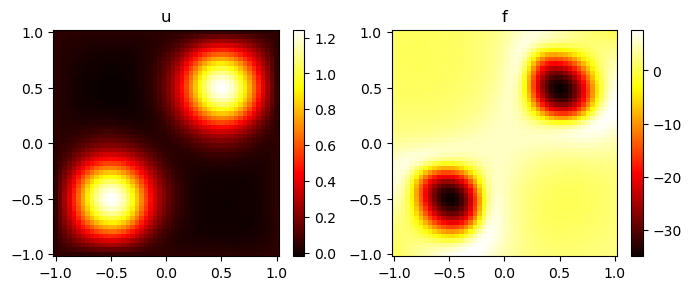

In [9]:
fig

# The Ground Truth Solution 

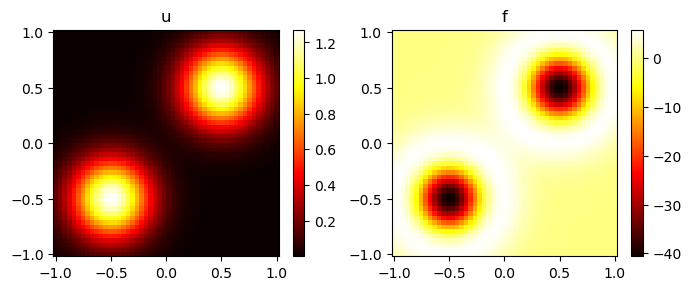

In [10]:
do_plot(x1_msh.detach().cpu().numpy(), x2_msh.detach().cpu().numpy(), 
        u_true.detach().cpu().numpy().reshape(*x1_msh.shape),
        f_true.detach().cpu().numpy().reshape(*x1_msh.shape))

# The Residual Error

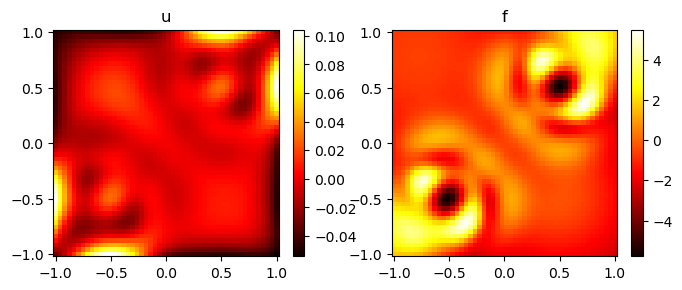

In [11]:
do_plot(x1_msh.detach().cpu().numpy(), x2_msh.detach().cpu().numpy(), 
        (u_true-u.ravel()).detach().cpu().numpy().reshape(*x1_msh.shape),
        (f_true-f.ravel()).detach().cpu().numpy().reshape(*x1_msh.shape))